In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import sys
import glob # List 불러오는 라이브러리
import numpy as np # 배열처리하는 라이브러리
# import pandas as pd #데이터 분석 라이브러리  (대용량 데이터 처리)
# from PIL import Image # Python Image Library 이미지 라이브러리
import cv2

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt# 이미지, 그래프 보는 라이브러리

from tqdm import tqdm, tqdm_notebook
import pandas as pd
import SimpleITK as sitk

from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('Worrying Stuff')


2024-07-03 16:35:29.403440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 16:35:30.260288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gil/anaconda3/envs/msb3/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:
2024-07-03 16:35:31.018037: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gil/anaconda3/envs/ms

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-07-03 16:35:32.237870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 16:35:33.063221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 78906 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17111705146934801289
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82739134464
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 3347568963122589986
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [3]:
# 전처리한 데이터 폴더 위치
base_dir = os.path.abspath(f'./data/data_preprocessing')

# 학습한 인공지능 모델 위치
saveDir= os.path.abspath(f'./result')

print(base_dir)
print(saveDir)


/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_2/data/data_preprocessing
/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_2/result


# 전처리한 데이터 불러오기

In [4]:
# 이미지 데이터 리스트 불러오기
image_list = sorted(glob.glob(f'{base_dir}/img*.png'))
print(len(image_list), image_list[0])


150 /home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_2/data/data_preprocessing/img_0.png


In [5]:
# 데이터 로드하는 함수 정의하기
def data_load(image_list, test:bool=False):
    image_data = []
    label_data = []
    
    for i in tqdm_notebook(range(len(image_list)), leave=False):
        image_path = image_list[i]
        label_path = image_path.replace('/img', '/lab')

        image = cv2.imread(image_path, 0)
        label = cv2.imread(label_path, 0) > 127.5
        
        image = image.astype(np.float32)
        label = label.astype(np.float32)
        
        image = image / 255.0
        label_max = np.max(label)
        if label_max > 1.0 :
            label = label / 255.0
                    
        image_data.append(image)
        label_data.append(label)
        
    image_data = np.array(image_data)
    label_data = np.array(label_data)
    
    image_data = np.expand_dims(image_data, -1)
    label_data = np.expand_dims(label_data, -1)

    print(image_data.shape, np.min(image_data), np.max(image_data))
    print(label_data.shape, np.min(label_data), np.max(label_data))
    
    return image_data, label_data

# 데이터 로드하기 
image_data, label_data = data_load(image_list)

/tmp/ipykernel_2232605/4090016382.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(image_list)), leave=False):


  0%|          | 0/150 [00:00<?, ?it/s]

(150, 128, 128, 1) 0.0 1.0
(150, 128, 128, 1) 0.0 1.0


In [6]:
# 학습용 데이터, 검증용 데이터, 데스트 데이터 분리하기 
train_ratio = int(0.8 * len(image_data))
validation_ratio = int(0.9 * len(image_data))

train_image = image_data[:train_ratio]
train_label = label_data[:train_ratio]
validation_image = image_data[train_ratio:validation_ratio]
validation_label = label_data[train_ratio:validation_ratio]
test_image = image_data[validation_ratio:]
test_label = label_data[validation_ratio:]

print('training dataset')
print(train_image.shape, np.min(train_image), np.max(train_image))
print(train_label.shape, np.min(train_label), np.max(train_label))
print('validatio dataset')
print(validation_image.shape, np.min(validation_image), np.max(validation_image))
print(validation_label.shape, np.min(validation_label), np.max(validation_label))
print('test dataset')
print(test_image.shape, np.min(test_image), np.max(test_image))
print(test_label.shape, np.min(test_label), np.max(test_label))

training dataset
(120, 128, 128, 1) 0.0 1.0
(120, 128, 128, 1) 0.0 1.0
validatio dataset
(15, 128, 128, 1) 0.0 0.99215686
(15, 128, 128, 1) 0.0 1.0
test dataset
(15, 128, 128, 1) 0.0 1.0
(15, 128, 128, 1) 0.0 1.0


# Model 정의하기

In [7]:
# 인공지능 모델 저장할 위치
model_name = f'model'
model_path = f'{saveDir}/{model_name}.h5'
best_model_path = f'{saveDir}/{model_name}_best.h5'

print(model_path)
print(best_model_path)


/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_2/result/model.h5
/home/gil/gcubme_ai2/Workspace/SB_MUN/20_강의_스마트헬스케어/project_2/result/model_best.h5


In [8]:
# 인공지능 모델 (U-Net) 정의하기

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dropout, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Activation, Conv2DTranspose, BatchNormalization, add, multiply
import tensorflow.keras.backend as K

def Conv2D_block(input_layer, out_n_filters, kernel_size=[3,3], stride=[1,1], padding='same'):
    
    layer = input_layer
    
    for i in range(2):
        
        layer = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding)(layer)
        layer = BatchNormalization()(layer) 
        layer = Activation('relu')(layer) # ReLU
        
    out_layer = layer
    
    return out_layer

def Up_and_Concate(down_layer, layer):
    
    input_channel = down_layer.get_shape().as_list()[3]
    output_channel = input_channel // 2
    
    up = UpSampling2D(size = (2,2))(down_layer)

    concate = concatenate([up, layer])
    return concate


def classifier(conv_last, n_label, activation):
    x = Conv2D(n_label, kernel_size=[1, 1], padding='same')(conv_last) # 필터셋개수=레이블개수, # 필터셋사이즈=[1,1], 패딩
    output = Activation(activation)(x)  
   
    return output

def build_model(input_shape, classes, activation='sigmoid'): # image Segmentation을 위한 Convolutional Network End-to-End 방식
        
    inputs = Input(input_shape, dtype = 'float32')
    x = inputs
    depth = 4 # 채널 개수
    features = 32 # 특징 개수
    down_layer = []
    
    
    for i in range(depth):
        
        x = Conv2D_block(x, features) 
        down_layer.append(x)
        x = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(x)

        features = features * 2
        
    x = Conv2D_block(x, features)
    
    for i in reversed(range(depth)):

        features = features // 2
        
        x = Up_and_Concate(x, down_layer[i])
        x = Conv2D_block(x, features)
    
    
    output = classifier(x, classes, activation)
    model = Model(inputs = inputs, outputs = output)
    
    return model


In [9]:
# 모델 빌드하기
inp_shape = train_image[0].shape
print(train_image[0].shape)

model = build_model(inp_shape, 1)
model.summary()


(128, 128, 1)


2024-07-03 16:35:33.875893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78906 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
# 모델 학습에 사용되는 metrix 와 loss function
def dice_coef(y_true, y_pred, smooth=0.001):
    y_true_f = K.flatten(y_true)# y_true를 일렬로 정렬한다.
    y_pred_f = K.flatten(y_pred) # y_pred를 일렬로 정렬한다.
    intersection = K.sum(y_true_f * y_pred_f)# y_true_f와 y_pred_f, 두 이미지를 곱해서 교집합을 구한다.
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# 모델 컴파일 하기
model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss, metrics=[dice_coef, 'acc'])

# 모델 학습에 사용되는 콜백함수 정의하기
checkpointer = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks_list = [reduce_lr, earlystopper]

print(train_image.shape, np.min(train_image), np.max(train_image))
print(train_label.shape, np.min(train_label), np.max(train_label))
print(validation_image.shape, np.min(validation_image), np.max(validation_image))
print(validation_label.shape, np.min(validation_label), np.max(validation_label))

(120, 128, 128, 1) 0.0 1.0
(120, 128, 128, 1) 0.0 1.0
(15, 128, 128, 1) 0.0 0.99215686
(15, 128, 128, 1) 0.0 1.0


In [11]:
from datetime import datetime
startTime = datetime.now()

batch_size = 4
epochs = 10

print('Start Time : {0}'.format(startTime))
hist = model.fit(train_image, train_label, batch_size=batch_size, epochs=epochs, verbose=1,
              validation_data= (validation_image, validation_label), 
              shuffle=True, callbacks=callbacks_list)

endTime = datetime.now()
runTime = endTime - startTime

print('End Time : {0}'.format(endTime))
print('Running Time : ' + str(runTime))

print('Done training')

Start Time : 2024-07-03 16:35:35.058272
Epoch 1/10


2024-07-03 16:35:39.166486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2024-07-03 16:35:41.247887: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f02571e7b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-03 16:35:41.247934: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-07-03 16:35:41.253067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-03 16:35:41.382745: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 [==============================] - 13s 40ms/step - loss: 0.6691 - dice_coef: 0.3309 - acc: 0.8792 - val_loss: 0.8918 - val_dice_coef: 0.1081 - val_acc: 0.0696 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 1s 22ms/step - loss: 0.5199 - dice_coef: 0.4801 - acc: 0.9549 - val_loss: 0.8746 - val_dice_coef: 0.1252 - val_acc: 0.8789 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 1s 22ms/step - loss: 0.4243 - dice_coef: 0.5757 - acc: 0.9658 - val_loss: 0.9290 - val_dice_coef: 0.0707 - val_acc: 0.9467 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 1s 21ms/step - loss: 0.3445 - dice_coef: 0.6555 - acc: 0.9717 - val_loss: 0.9419 - val_dice_coef: 0.0580 - val_acc: 0.9467 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 1s 22ms/step - loss: 0.2788 - dice_coef: 0.7212 - acc: 0.9767 - val_loss: 0.9640 - val_dice_coef: 0.0359 - val_acc: 0.9467 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 1s 22ms/step - los

# Test Model

In [12]:
# 검증 데이터셋에서 가장 성능이 좋았던 베스트 모델 로드하기
from tensorflow.keras.models import load_model
model = load_model(best_model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

# 모델 히스토리 불러오기
hist = pd.read_excel(f"{saveDir}/history.xlsx")

In [13]:
# 데이터 성능 검증 지표 계산하는 함수 정의하기 
def resultConf(test_label, predict_model, weight):
    recall_list = []
    specificity_list = []
    precision_list = []
    acc_list = []
    dice_list = []
    
    all_data_result = []
    ious = []
    dices = []
    
    #for i in range(n_test):
    for i in tqdm_notebook(range(test_label.shape[0])):
            
        gt = test_label[i, :,  :, 0] # ground truth binary mask
        
        if np.sum(gt) > 0:
            pr = predict_model[i, :, :, 0] > weight# binary prediction
        
            gt = gt.astype(bool)
            pr = pr.astype(bool)
        
            # Compute scores
            seg1_n = pr == 0
            seg1_t = pr == 1
        
            gt1_n = gt == 0
            gt1_t = gt == 1
            
            tp = np.sum(seg1_t&gt1_t)
            fp = np.sum(seg1_t&gt1_n)
            tn = np.sum(seg1_n&gt1_n)    
            fn = np.sum(seg1_n&gt1_t)
            
            recall = tp / (tp + fn)
            specificity = tn / (tn + fp)
            precision = tp / (tp + fp)
            acc = (tp + tn) / (tp + tn + fp + fn)
            dice = (2 * tp) / (2*tp + fp + fn)
            
            recall_list.append(recall)
            specificity_list.append(specificity)
            precision_list.append(precision)
            acc_list.append(acc)
            dice_list.append(dice)
            
                
    dice_list = np.array(dice_list)
    recall_list = np.array(recall_list)
    specificity_list = np.array(specificity_list)
    precision_list = np.array(precision_list)
    
    dice_list = dice_list[~np.isnan(dice_list)]
    recall_list = recall_list[~np.isnan(recall_list)]
    specificity_list = specificity_list[~np.isnan(specificity_list)]
    precision_list = precision_list[~np.isnan(precision_list)]
    
    print('Done save result...')
    
    return recall_list, specificity_list, precision_list, acc_list, dice_list

def returnTable(test_label, predict_model, weight):
    recall_list, specificity_list, precision_list, acc_list, dice_list = resultConf(test_label, predict_model, weight)

    row_data1 = []
    row_item1 = []
    
    row_item1.append('{0}'.format(weight))
    row_item1.append('{0:.2f}'.format(np.mean(recall_list)*100))
    row_item1.append('{0:.2f}'.format(np.mean(specificity_list)*100))
    row_item1.append('{0:.2f}'.format(np.mean(precision_list)*100))
    row_item1.append('{0:.2f}'.format(np.mean(acc_list)*100))
    row_item1.append('{0:.2f}'.format(np.mean(dice_list)*100))
    row_data1.append(row_item1)
    
    head1 = ["Weight", "Sensitivity", "Specificity", "Precision", "Accuracy", "DSC"]
    
    return row_data1, head1

In [14]:
# 테스트 데이터셋을 사용한 모델 예측
predicted = model.predict(test_image, batch_size=4, verbose=1)

print(test_image.shape, np.min(test_image), np.max(test_image))
print(test_label.shape, np.min(test_label), np.max(test_label))
print(predicted.shape, np.min(predicted), np.max(predicted))


4/4 [==============================] - 0s 7ms/step
(15, 128, 128, 1) 0.0 1.0
(15, 128, 128, 1) 0.0 1.0
(15, 128, 128, 1) 4.024541e-06 1.0


In [15]:
# 테스트 데이터셋의 성능 검증 결과
from tabulate import tabulate

row_data1, head1 = returnTable(test_label, predicted, 0.5)
print(tabulate(row_data1, headers=head1, tablefmt="grid"))


/tmp/ipykernel_2232605/3733576720.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(test_label.shape[0])):


  0%|          | 0/15 [00:00<?, ?it/s]

Done save result...
+----------+---------------+---------------+-------------+------------+-------+
|   Weight |   Sensitivity |   Specificity |   Precision |   Accuracy |   DSC |
+==========+===============+===============+=============+============+=======+
|      0.5 |         84.67 |         99.32 |        88.1 |      98.47 | 86.26 |
+----------+---------------+---------------+-------------+------------+-------+


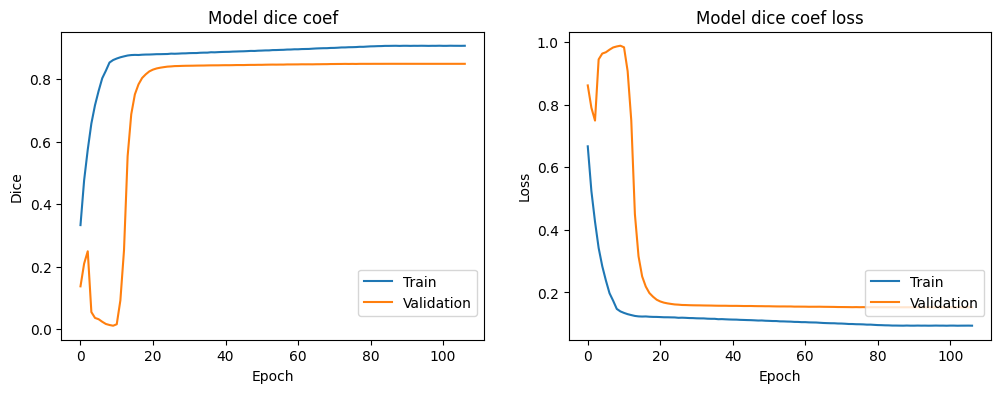

In [16]:
# 모델 학습 히스토리 시각화
fig = plt.figure(figsize=(12, 4))
    
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hist['dice_coef'])
ax1.plot(hist['val_dice_coef'])
ax1.set_title('Model dice coef')
ax1.set_ylabel('Dice')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 0.25))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(hist['loss'])
ax2.plot(hist['val_loss'])
ax2.set_title('Model dice coef loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 0.25))



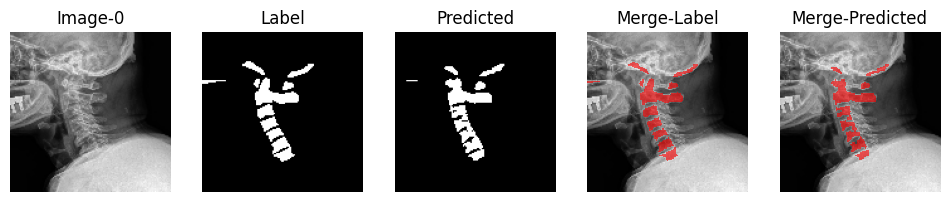

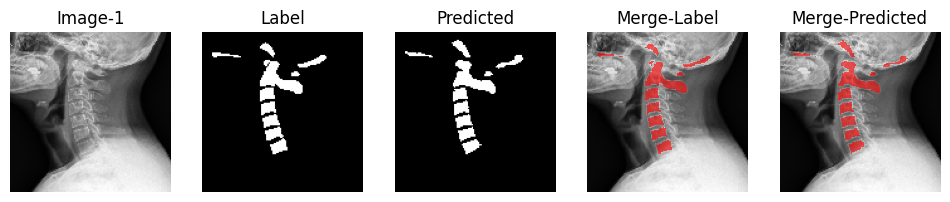

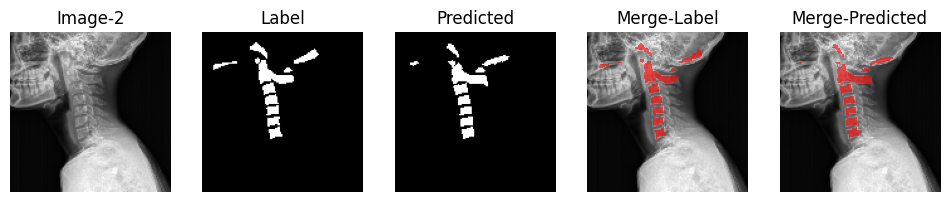

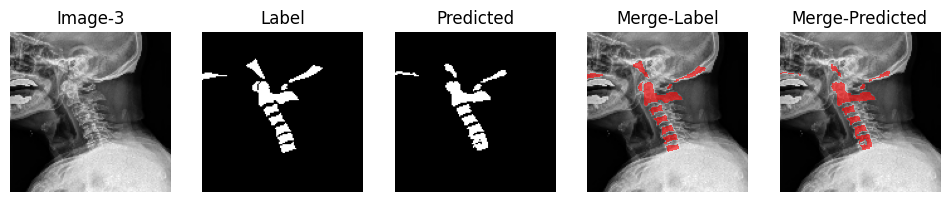

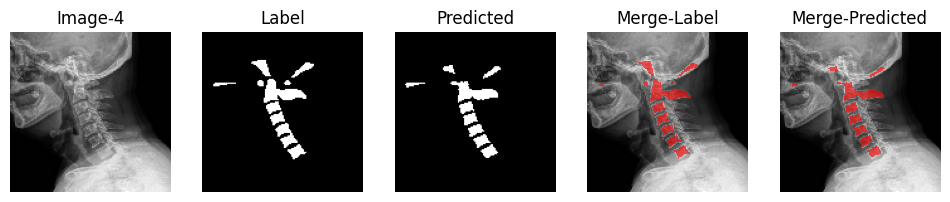

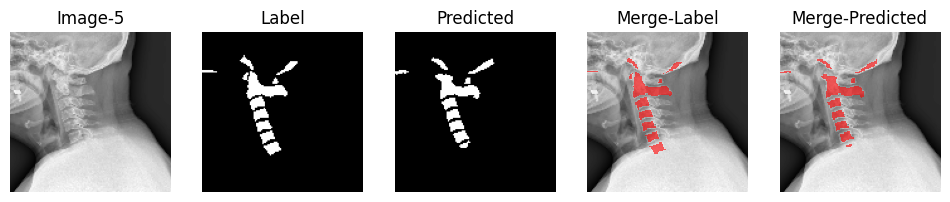

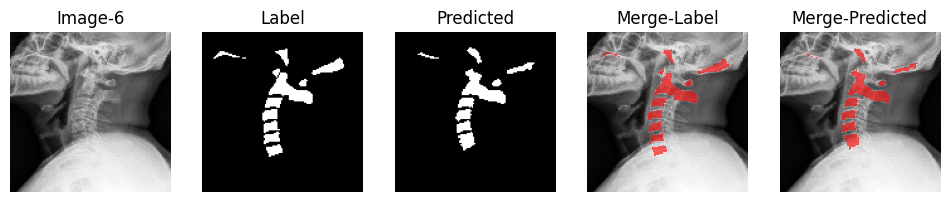

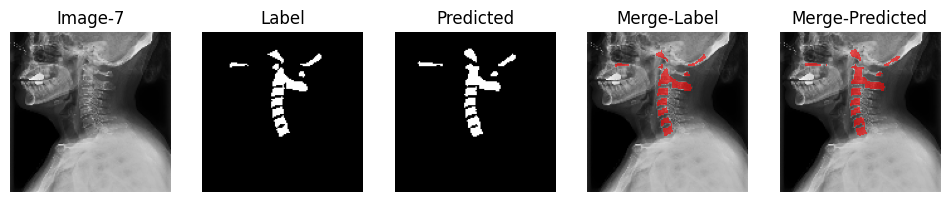

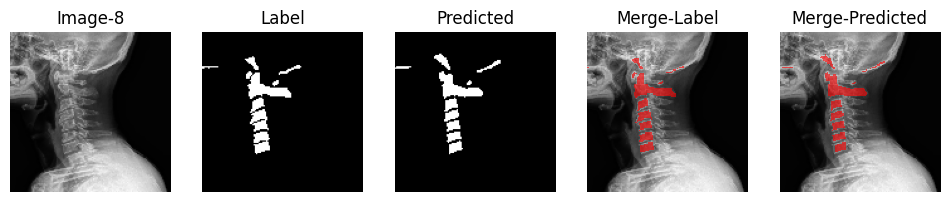

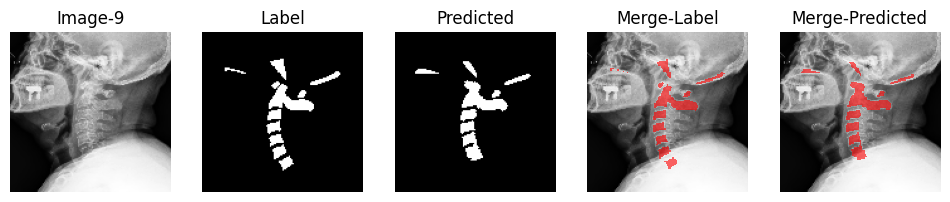

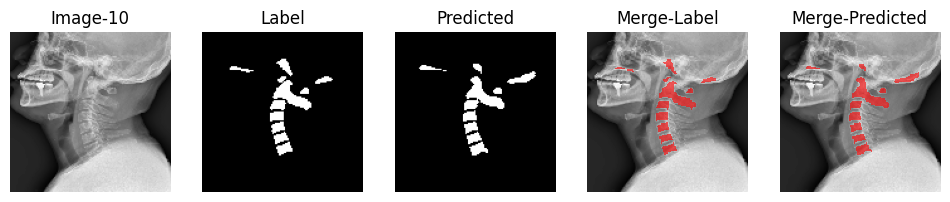

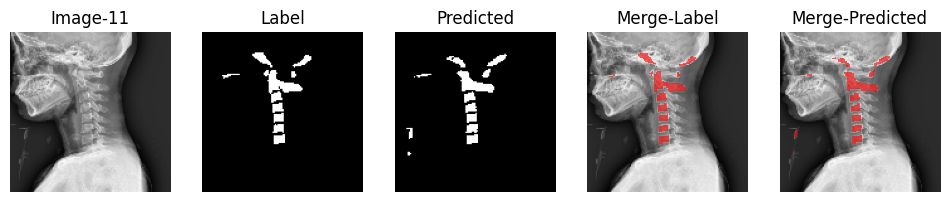

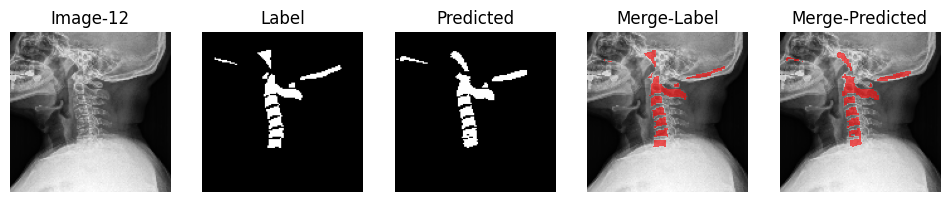

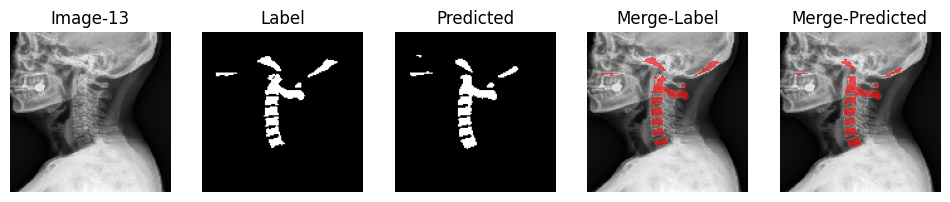

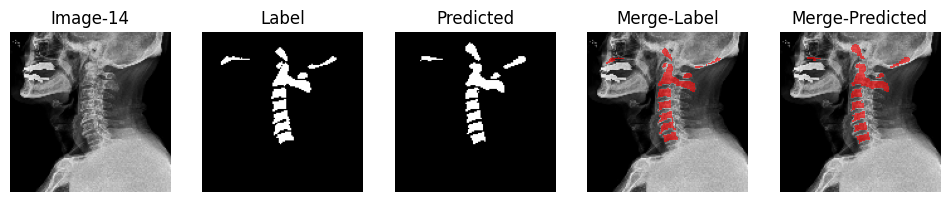

In [17]:
for i in range(0, len(test_image)):
    image = test_image[i, :, :, 0]
    label = test_label[i, :, :, 0]
    predi = predicted[i, :, :, 0] > 0.5
    
    fig = plt.figure(figsize=(12, 12))
    
    ax1 = fig.add_subplot(2,5,1)
    ax1.imshow(image,cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'Image-{i}')
    
    ax2 = fig.add_subplot(2,5,2)
    ax2.imshow(label,cmap='gray')
    ax2.axis('off')
    ax2.set_title('Label')
        
    ax3 = fig.add_subplot(2,5,3)
    ax3.imshow(predi,cmap='gray')
    ax3.axis('off')
    ax3.set_title('Predicted')
    
    ax4 = fig.add_subplot(2,5,4)
    ax4.imshow(image,cmap='gray')
    tmpMask = label
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax4.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax4.axis('off')
    ax4.set_title('Merge-Label');
    
    ax5 = fig.add_subplot(2,5,5)
    ax5.imshow(image,cmap='gray')
    tmpMask = predi
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax5.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax5.axis('off')
    ax5.set_title('Merge-Predicted')